# Clustering Wholesale Customer

### Import Library

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, Normalizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

### Load Data

In [30]:
df = pd.read_csv("../data/Wholesale_customers_data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Exploration Data Analysis (EDA)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [32]:
df.describe(include='all')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [33]:
df.isnull().sum()


Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [34]:
df.duplicated().sum()

0

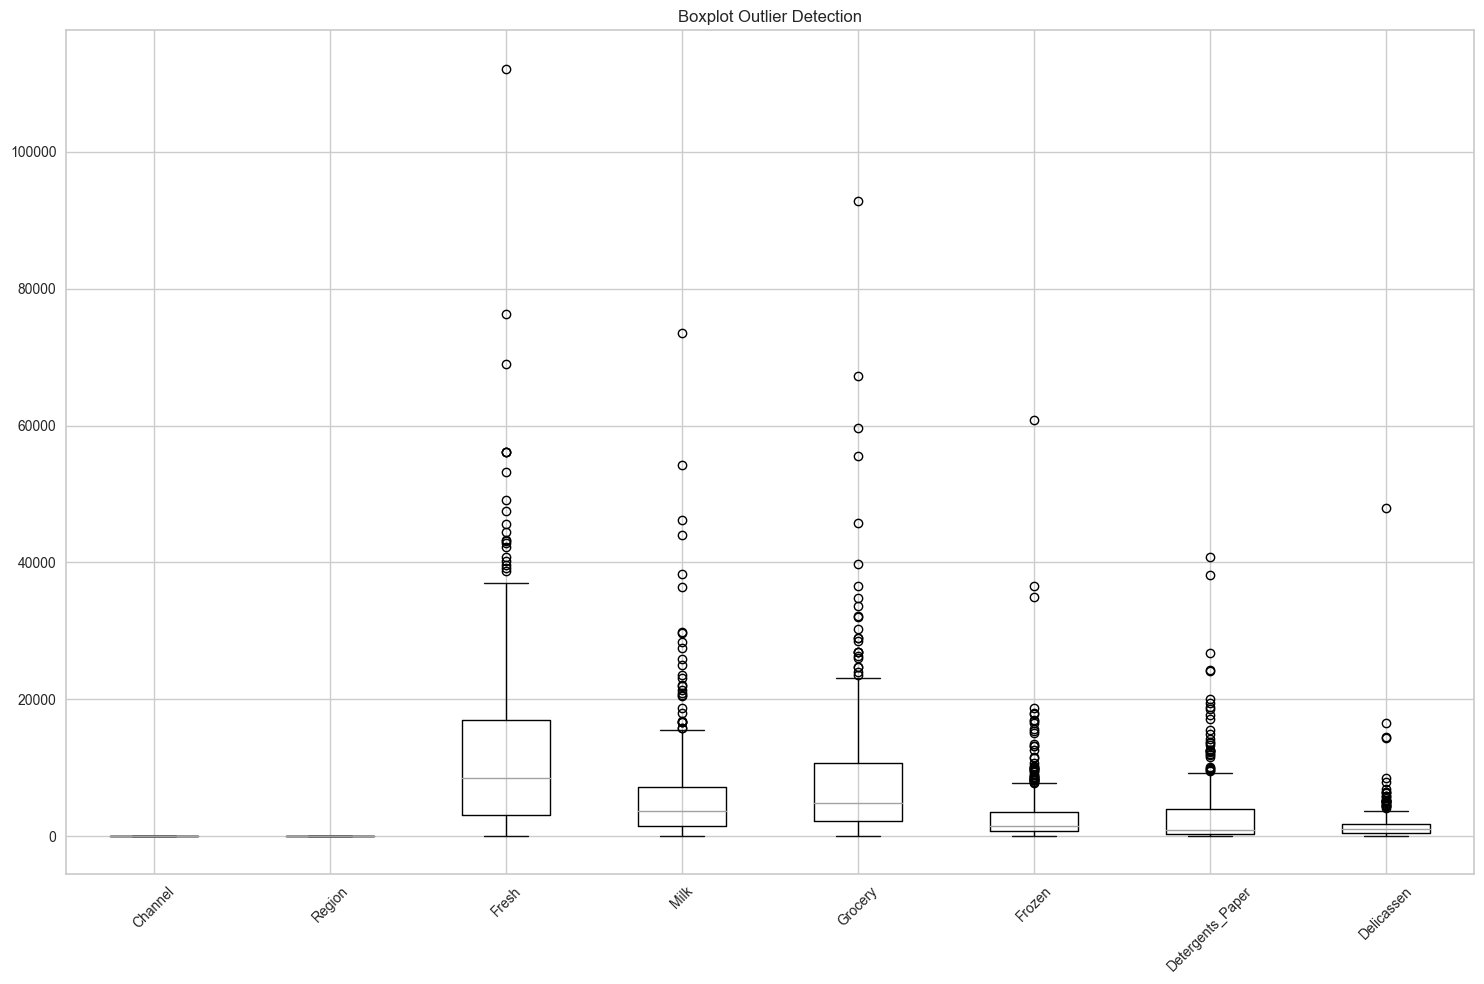

In [35]:
plt.figure(figsize=(15, 10))
df.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot Outlier Detection")
plt.tight_layout()
plt.show()

In [36]:
def detect_outlier(data):
    outliers_dict = {}
    for col in data.select_dtypes('number').columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
        outliers_dict[col] = {
            'count': outliers,
            'percentage': (outliers/ len(data)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    return pd.DataFrame(outliers_dict).T

summary_outliers = detect_outlier(df)
summary_outliers

,count,percentage,lower_bound,upper_bound
Channel,0.0,0.000000,-0.500,3.500
Region,0.0,0.000000,0.500,4.500
Fresh,20.0,4.545455,-17581.250,37642.750
Milk,28.0,6.363636,-6952.875,15676.125
Grocery,24.0,5.454545,-10601.125,23409.875
Frozen,43.0,9.772727,-3475.750,7772.250
Detergents_Paper,30.0,6.818182,-5241.125,9419.875
Delicassen,27.0,6.136364,-1709.750,3938.250


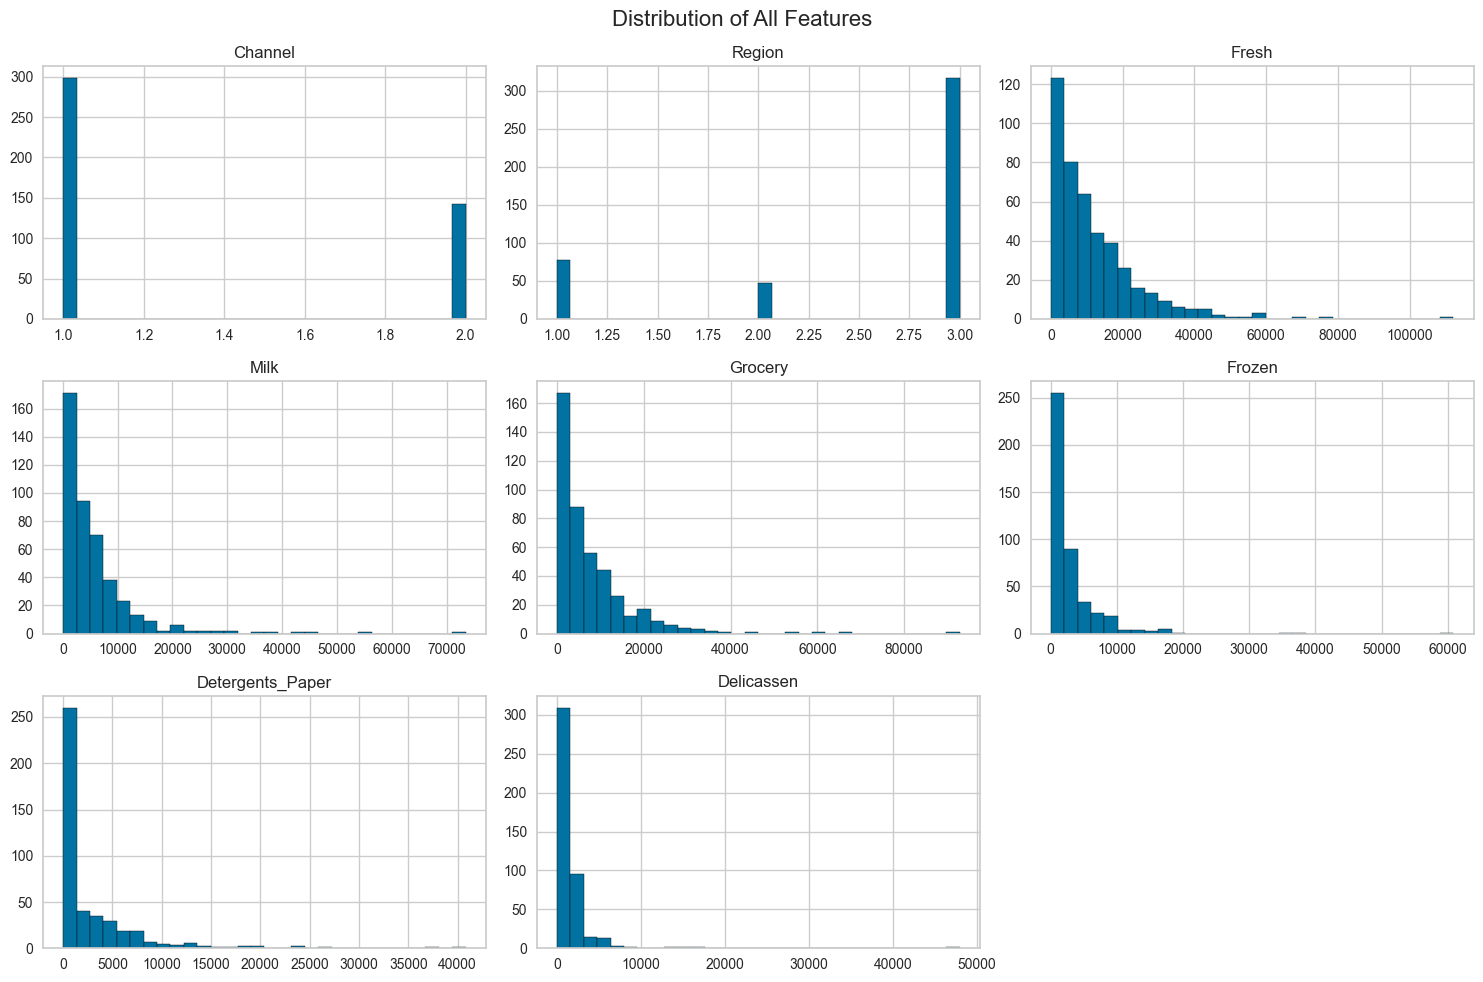

In [37]:
df.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of All Features', fontsize=16)
plt.tight_layout()
plt.show()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

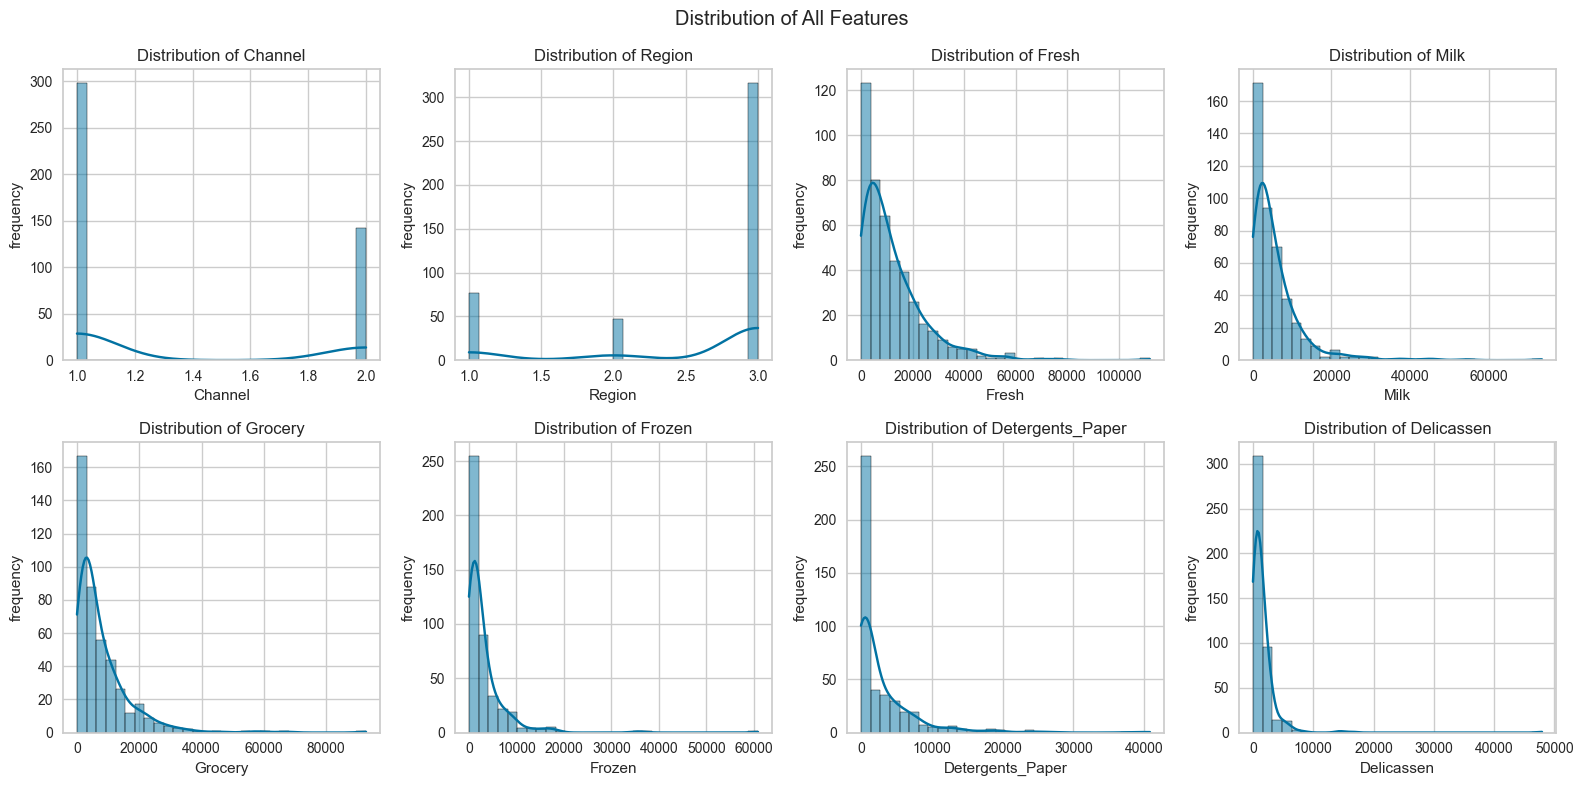

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('frequency')

plt.suptitle('Distribution of All Features')
plt.tight_layout()
plt.show()

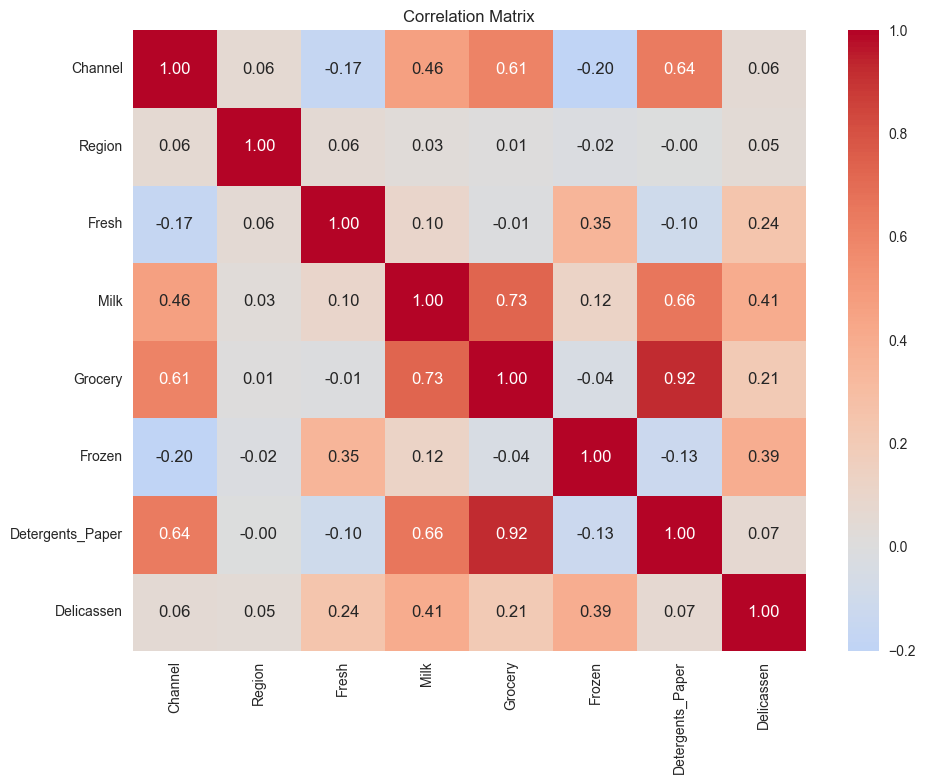

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Data Cleaning and Transformation

In [40]:
x_scaled = df.drop(columns=['Channel', 'Region'], axis=1)
def cap_outliers(data):
    df_capped = data.copy()
    for col in data.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_capped

x_scaled = cap_outliers(x_scaled)
x_scaled.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.00000,440.000000,440.000000,440.000000
mean,11357.568182,5048.592045,7236.37500,2507.085795,2392.616477,1266.715341
std,10211.542235,4386.377073,6596.53308,2408.297738,2940.794090,1083.069792
min,3.000000,55.000000,3.00000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.00000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.50000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.75000,3554.250000,3922.000000,1820.250000
max,37642.750000,15676.125000,23409.87500,7772.250000,9419.875000,3938.250000


In [41]:
scaler = MinMaxScaler()
x_scaled_array = scaler.fit_transform(x_scaled)

x_scaled = pd.DataFrame(x_scaled_array, columns=x_scaled.columns, index=x_scaled.index)
x_scaled

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.336506,0.614616,0.322897,0.024396,0.283640,0.339241
1,0.187408,0.624475,0.408641,0.224209,0.349373,0.450543
2,0.168705,0.560331,0.328151,0.307206,0.373054,1.000000
3,0.352340,0.073042,0.180203,0.823389,0.053521,0.453593
4,0.600748,0.342805,0.307388,0.502114,0.188385,1.000000
...,...,...,...,...,...,...
435,0.789059,0.767934,0.684585,1.000000,0.019008,0.559304
436,1.000000,0.088086,0.032512,0.578915,0.009557,0.595388
437,0.385975,0.987957,1.000000,0.053180,1.000000,0.473667
438,0.273301,0.123295,0.095228,0.130756,0.017522,0.539229


In [42]:
outlier_summary = detect_outlier(x_scaled).T
outlier_summary

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,20.000000,0.000000,0.000000,43.000000,0.000000,0.000000
percentage,4.545455,0.000000,0.000000,9.772727,0.000000,0.000000
lower_bound,-0.467172,-0.448615,-0.453035,-0.451870,-0.556886,-0.435233
upper_bound,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


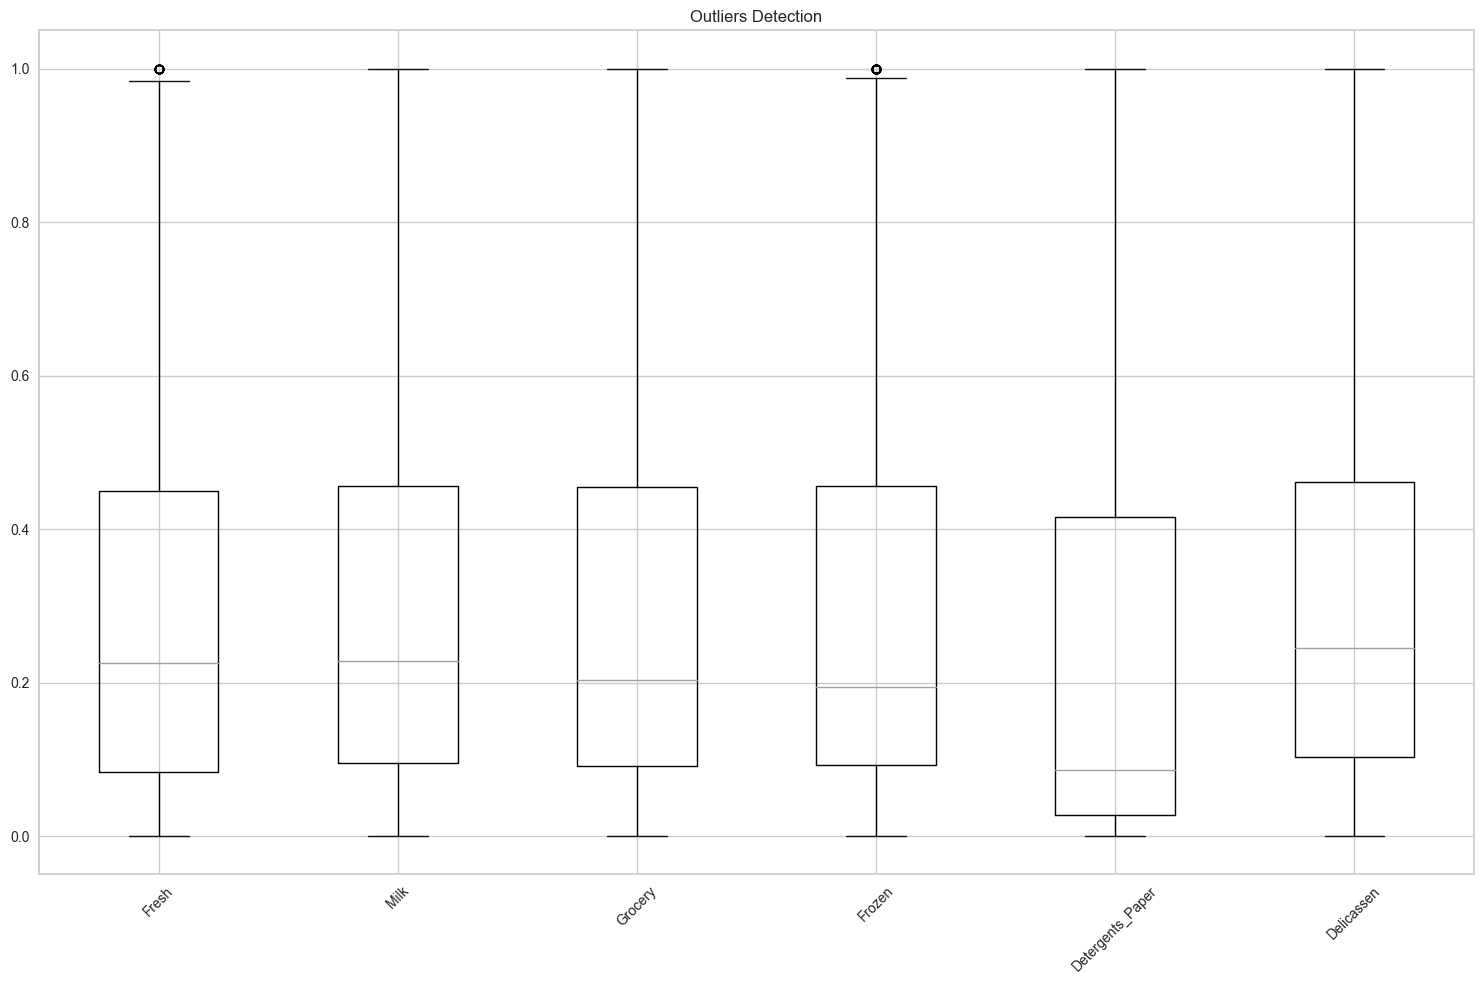

In [43]:
plt.figure(figsize=(15, 10))
x_scaled.boxplot()
plt.xticks(rotation=45)
plt.title('Outliers Detection')
plt.tight_layout()
plt.show()

### Clustering

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

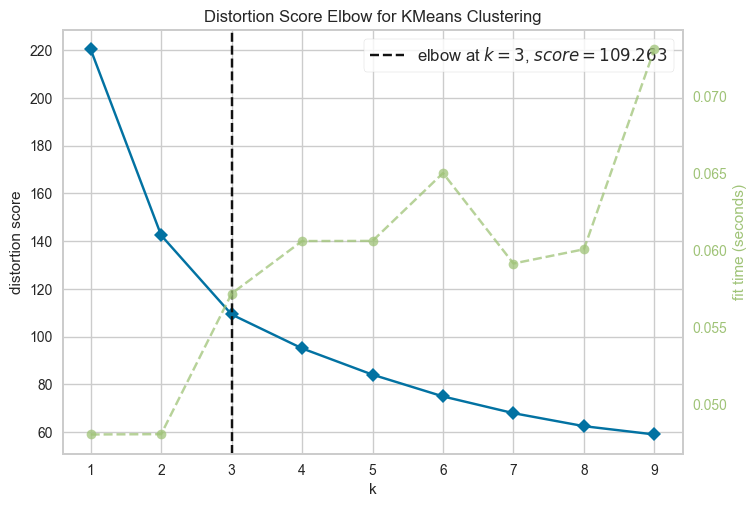

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
model = KMeans()

visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(x_scaled)
visualizer.show()

In [45]:
results = []

for k in range(2, 8):
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(x_scaled)
    sil_score = silhouette_score(x_scaled, labels)
    inertia = kmeans_temp.inertia_
    davies_bouldin = davies_bouldin_score(x_scaled, labels)
    calinski_harabasz = calinski_harabasz_score(x_scaled, labels)

    results.append({
        'K': k,
        'Inertia': inertia,
        'SilHouette Score': sil_score,
        'Davies Bouldin Score': davies_bouldin,
        'Calinski Harabasz': calinski_harabasz
    })

results_df = pd.DataFrame(results).T
results_df

,0,1,2,3,4,5
K,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Inertia,142.417881,109.263465,95.010376,84.050624,75.310291,67.933684
SilHouette Score,0.377410,0.340326,0.328632,0.296330,0.281548,0.288134
Davies Bouldin Score,1.149706,1.174904,1.268511,1.247173,1.201785,1.213481
Calinski Harabasz,239.462381,222.006242,191.620027,176.262505,167.087309,161.839375


In [46]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_scaled)
df['Cluster'] = kmeans.labels_

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [47]:
joblib.dump(kmeans, '../models/wholesale_customers_cluster.pkl')

['../models/wholesale_customers_cluster.pkl']

In [48]:
silhouette_avg = silhouette_score(x_scaled, df['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.3403255053262128


In [49]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,1


In [50]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(x_scaled)

print(f'PC1: {pca.explained_variance_ratio_[0]:.2f}')
print(f'PC2: {pca.explained_variance_ratio_[1]:.2f}')
print(f'Total: {sum(pca.explained_variance_ratio_):.2f}')

pca_features = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=x_scaled.columns
)
pca_features

PC1: 0.46
PC2: 0.27
Total: 0.84


,PC1,PC2,PC3
Fresh,-0.115495,0.502682,-0.504332
Milk,0.501967,0.173972,0.027990
Grocery,0.553627,0.065531,0.067182
Frozen,-0.161491,0.680227,0.710946
Detergents_Paper,0.605087,-0.081443,0.152958
Delicassen,0.189678,0.493364,-0.459905


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


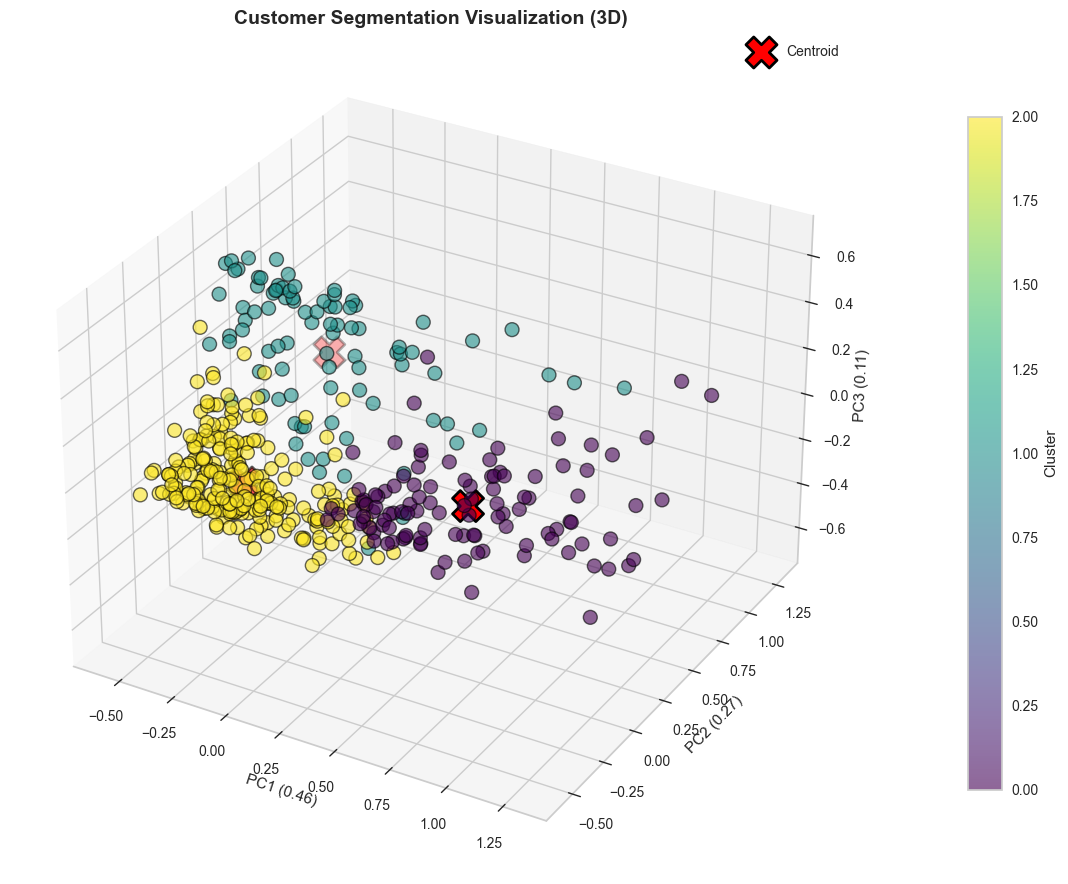

In [51]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_components[:, 0],
                     pca_components[:, 1],
                     pca_components[:, 2],
                     c=df['Cluster'],
                     cmap='viridis',
                     s=100,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=1)

centroids_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids_pca[:, 0],
           centroids_pca[:, 1],
           centroids_pca[:, 2],
           marker='X',
           s=500,
           c='red',
           edgecolors='black',
           linewidth=2,
           label='Centroid')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2f})')
ax.set_title('Customer Segmentation Visualization (3D)', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='Cluster', pad=0.1, shrink=0.8)
ax.legend()

plt.tight_layout()
plt.show()

In [52]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,1


In [53]:
features = [col for col in df.columns if col not in ['Cluster', 'Channel', 'Region']]
cluster_analysis = df.groupby('Cluster')[features].agg(['mean', 'min', 'max'])

cluster_analysis.round().T

Cluster                      0         1        2
Fresh            mean   7264.0   21662.0  10488.0
                 min      18.0       3.0      3.0
                 max   44466.0  112151.0  43088.0
Milk             mean  12741.0    5195.0   2870.0
                 min    1275.0     333.0     55.0
                 max   73498.0   43950.0  13252.0
Grocery          mean  19360.0    4969.0   3901.0
                 min    7677.0       3.0    137.0
                 max   92780.0   21042.0  16966.0
Frozen           mean   1514.0    9174.0   1466.0
                 min      25.0    1729.0     47.0
                 max    7782.0   60869.0   5500.0
Detergents_Paper mean   8801.0     801.0    982.0
                 min     282.0       3.0      3.0
                 max   40827.0    4948.0   5316.0
Delicassen       mean   1912.0    2661.0    918.0
                 min       3.0       3.0      3.0
                 max   16523.0   47943.0   5137.0

In [54]:
df.to_csv('../data/Wholesale_customer_cluster_data.csv', index=False)

### Interpretation (Indonesian)

#### **Segmen 0: Toko Retail Besar (Supermarket)**
Segmen ini adalah klaster dengan pembelian paling tinggi pada kategori 'Milk', 'Grocery' dan 'Detergents Paper'.

* **Karakteristik Utama (Berdasarkan nilai 'mean'):**
    * **Sangat Tinggi:** Milk (12740), Grocery (19360), dan Detergents Paper (8801). Nilai-nilai ini sangat tinggi dibandingkan segmen-segmen lain.
    * **Sedang:** Delicassen (1912).
    * **Rendah:** Fresh (7263).
    * **Sangat Rendah**: Frozen (1513)
* **Interpretasi:**
    * Segmen ini adalah **toko retail, supermarket atau minimarket.** Pola belanja mereka sangat jelas, mereka membeli produk-produk yang dapat dijual kembali kepada konsumen berdasarkan banyaknya rata-rata dari produk yang mereka beli.
    * Pada matriks korelasi sebelumnya sangat kuat pada kategori Milk, Grocery, dan Detergents Paper, dan korelasi tersebut tercermin sempurna pada segmen ini.
    * Mereka tidak terlalu fokus untuk membeli produk bahan mentah seperti 'Fresh' dan 'Frozen' dalam jumlah besar dibandingkan dengan segmen lain.
* **Rekomendasi Bisnis:**
    * **Strategi Penjualan:** Tawarkan **bundling** pada produk 'Milk', 'Grocery', dan 'Detergents Paper'. Karena volume penjualan pada segmen ini sangat tinggi, program loyalitas atau diskon dapat efektif untuk meningkatkan penjualan produk.
    * **Manajemen Pelanggan:** Pelanggan dalam segmen ini sangat bernilai tinggi bagi penjualan produk. Menugaskan **Account Manager** untuk dapat berhubungan baik dan menjalin kerja sama yang kuat untuk memastikan kebutuhan stok mereka terpenuhi.
    * **Pemasaran:** Tawarkan produk-produk terbaru yang relevan bagi kebutuhan mereka, seperti produk-produk yang sedang tren.

#### **Segmen 1: Hotel, Restoran, dan Kafe**
Segmen ini adalah klaster dengan pembelian paling tinggi pada kategori 'Fresh', 'Frozen', dan 'Delicassen'.

* **Karakteristik Utama (Berdasarkan nilai mean):**
    * **Sangat Tinggi:** Fresh (21662) dan Frozen (9174). Nilai-nilai ini sangat dominan dibandingkan dengan segmen lain.
    * **Tinggi:** Delicassen (2661), tertinggi di antara segmen-segmen lain.
    * **Rendah:** Milk (5195), Grocery (4969).
    * **Sangat Rendah:** Detergents Paper (801).
* **Interpretasi:**
    * Ini adalah segmen **Hotel, Restoran, dan Kafe** dalam skala besar. Fokus mereka adalah membeli bahan baku yang diolah menjadi makanan.
    * Pembelian 'Fresh' dan 'Frozen' yang masif menunjukkan bahwa mereka melayani pelanggan mereka setiap hari. Pembelian Delicassen yang tinggi juga sesuai dengan profil mereka, misalnya untuk menyediakan menu baru, hidangan pembuka atau hidangan spesial.
    * Mereka sedikit membeli 'Grocery', 'Detergents Paper', dan 'Milk' ini menunjukkan bahwa produk ini bukan bagian dari kebutuhan utama bisnis mereka.
* **Rekomendasi Bisnis:**
    * **Fokus pada Kualitas & Logistik**: Untuk segmen ini, terlihat pada bahan baku utama mereka, yaitu 'Fresh' dan 'Frozen', sehingga untuk menjaga kualitas bahan baku untuk mereka, haruslah dikirim secepat mungkin dan se efisien mungkin ke tempat mereka, untuk menjaga kepercayaan dan profesionalisme sebagai penyedia bahan baku untuk mereka.
    * **Strategi Harga:** Menawarkan kontrak jangka panjang atau diskon untuk produk 'Fresh' dan 'Frozen'.
    * **Cross-Selling:** Promosikan produk 'Delicassen' yang berkualitas tinggi kepada mereka, untuk meningkatkan variasi menu bagi mereka.

#### **Segmen 2: Toko Retail Kecil (Toko Kelontong, Penjual di Pasar Tradisional)**
Segmen ini merupakan frekuensi pembelian versi lebih rendah & campuran dari kedua segmen sebelumnya.

* **Karakteristik Utama:**
    * **Sedang**: Fresh (10488).
    * **Rendah**: Milk (2870), Grocery (3901), Delicassen (918).
    * **Sangat Rendah**: Frozen (1466), Detergents Paper (982).
* **Interpretasi:**
    * Ini adalah segmen untuk toko retail kecil seperti toko kelontong dan penjual pasar tradisional, yang dimana intensitas pembelian mereka terhadap produk-produk tersebut tidak dominan tinggi, ini berarti mereka menyesuaikan target pembeli mereka yang tidak sebanyak toko retail yang besar.
    * Pembelian yang sedang seperti 'Fresh' yang menandakan bahwa mereka memang dari toko retail kecil seperti toko kelontong dan penjual di pasar tradisional, yang dimana kebutuhan akan bahan-bahan mentah yang segar untuk dijual dalam jumlah yang sedang, sesuai jumlah target pembeli.
    * Pembelian terhadap produk 'Milk', 'Grocery, 'Delicassen', 'Frozen', dan 'Detergents Paper' yang rendah, cukup mencerminkan bahwa mereka berasal dari toko kelontong dan penjual di pasar, fokus mereka adalah pembelian bahan-bahan segar yang dapat dibeli secara efisien oleh target pembeli mereka yang dekat dengan area penjualan mereka.
* **Rekomendasi Bisnis**:
    * **Strategi Penjualan**: Dalam penjualan produk 'Fresh' untuk segmen ini sangat diutamakan bagi mereka, karena kebutuhan utama dari bisnis mereka adalah dari produk 'Fresh', sehingga untuk harga yang ditetapkan selalu konstan di harga normal tanpa ada promo atau diskon bagi mereka, ini akan menyeimbangkan antara segmen 0 (toko retail besar) dan segmen 2 (toko retail kecil), karena di segmen 2 mempunyai keuntungan target pembeli yang lebih konsisten daripada segmen 0 yang jauh dari rumah target pembeli dan kurang konsisten terhadap pembelian produk tersebut dari target pembeli mereka. Dengan cara ini kedua segmen masih tetap punya daya beli akan kebutuhan terhadap produk tersebut.
    * **Strategi Promosi:** Selalu memberikan promosi produk-produk yang relevan terhadap produk 'Fresh' yang terbaru dan sedang tren.

### Interpretation (English)

#### **Segment 0: Large Retail Store (Supermarket)**
This segment is the cluster with the highest purchases in the 'Milk', 'Grocery', and 'Detergents Paper' categories.

* **Key Characteristics (Based on 'mean' values):**
    * **Very High:** Milk (12740), Grocery (19360), and Detergents Paper (8801). These values are significantly high compared to other segments.
    * **Medium:** Delicatessen (1912).
    * **Low:** Fresh (7263).
    * **Very Low**: Frozen (1513)
* **Interpretation:**
    * This segment consists of **retail stores, supermarkets, or minimarts.** Their purchasing pattern is very clear; they buy products that can be resold to consumers, based on the high average quantity of products they purchase.
    * The previous correlation matrix showed a very strong correlation in the Milk, Grocery, and Detergents Paper categories, and that correlation is perfectly reflected in this segment.
    * They are not as focused on buying raw products like 'Fresh' and 'Frozen' in large quantities compared to other segments.
* **Business Recommendations:**
    * **Sales Strategy:** Offer **bundling** for 'Milk', 'Grocery', and 'Detergents Paper' products. Because sales volume in this segment is very high, loyalty programs or discounts can be effective in increasing product sales.
    * **Customer Management:** Customers in this segment are highly valuable to sales. Assign an **Account Manager** to maintain good relationships and build strong partnerships to ensure their stock needs are met.
    * **Marketing:** Offer the latest products that are relevant to their needs, such as trending products.

#### **Segment 1: Hotels, Restaurants, and Cafes**
This segment is the cluster with the highest purchases in the 'Fresh', 'Frozen', and 'Delicatessen' categories.

* **Key Characteristics (Based on mean values):**
    * **Very High:** Fresh (21662) and Frozen (9174). These values are very dominant compared to other segments.
    * **High:** Delicatessen (2661), the highest among all segments.
    * **Low:** Milk (5195), Grocery (4969).
    * **Very Low:** Detergents Paper (801).
* **Interpretation:**
    * This is the segment for large-scale **Hotels, Restaurants, and Cafes**. Their focus is on purchasing raw materials that are processed into food.
    * The massive purchases of 'Fresh' and 'Frozen' indicate that they serve their customers daily. The high purchase of Delicatessen items also fits their profile, for example, to provide new menus, appetizers, or special dishes.
    * Their low purchases of 'Grocery', 'Detergents Paper', and 'Milk' indicate that these products are not part of their core business needs.
* **Business Recommendations:**
    * **Focus on Quality & Logistics**: For this segment, their main raw materials are 'Fresh' and 'Frozen'. To maintain the quality of these materials, they must be delivered as quickly and efficiently as possible to their locations to maintain trust and professionalism as their supplier.
    * **Pricing Strategy:** Offer long-term contracts or discounts for 'Fresh' and 'Frozen' products.
    * **Cross-Selling:** Promote high-quality 'Delicatessen' products to them to increase their menu variety.

#### **Segment 2: Small Retail Stores (Grocery Stalls, Traditional Market Vendors)**
This segment represents a lower-frequency purchasing version and a mix of the previous two segments.

* **Key Characteristics:**
    * **Medium**: Fresh (10488).
    * **Low**: Milk (2870), Grocery (3901), Delicatessen (918).
    * **Very Low**: Frozen (1466), Detergents Paper (982).
* **Interpretation:**
    * This segment is for small retail stores like grocery stalls and traditional market vendors, whose purchasing intensity for these products is not dominantly high. This means they are adjusting to their target customers, who are not as numerous as those of large retailers.
    * The medium purchase of 'Fresh' products indicates that they are indeed small retail businesses like grocery stalls and traditional market vendors, whose need for fresh raw materials to sell is moderate, aligning with their target customer base.
    * The low purchases of 'Milk', 'Grocery, 'Delicatessen', 'Frozen', and 'Detergents Paper' products reflect their nature as grocery stalls and market vendors. Their focus is on fresh ingredients that can be efficiently purchased by their target buyers, who are close to their sales area.
* **Business Recommendations**:
    * **Sales Strategy**: For this segment, selling 'Fresh' products is a top priority, as it's the core need of their business. Therefore, the price should be set consistently at a normal rate without promotions or discounts. This will create a balance between Segment 0 (large retail stores) and Segment 2 (small retail stores), because Segment 2 has the advantage of a more consistent customer base than Segment 0, which is further from customers' homes and sees less consistent purchasing from them. This way, both segments maintain their purchasing power for these products.
    * **Promotional Strategy:** Always provide promotions for relevant products that are new and trending within the 'Fresh' category.